Compare 3D reoriented reconstructions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
with h5py.File("vols/X20_FDK_rot.h5", "r") as f:
    vol_FDK = f["vol"][:]

with h5py.File("vols/X20_BHC_rot.h5", "r") as f:
    vol_BHC = f["vol"][:]

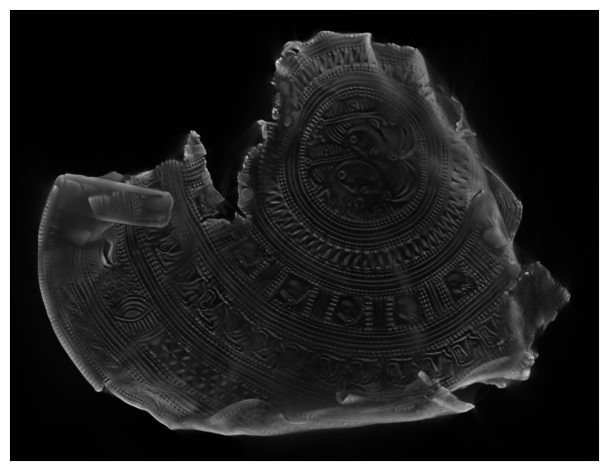

In [4]:
# fig, ax = plt.subplots(figsize=(8,5))
# plt.sca(ax)
plt.imshow(np.max(vol_FDK,axis=2).T, origin='upper', cmap='gray')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig('plots/X20_MIP.pdf')

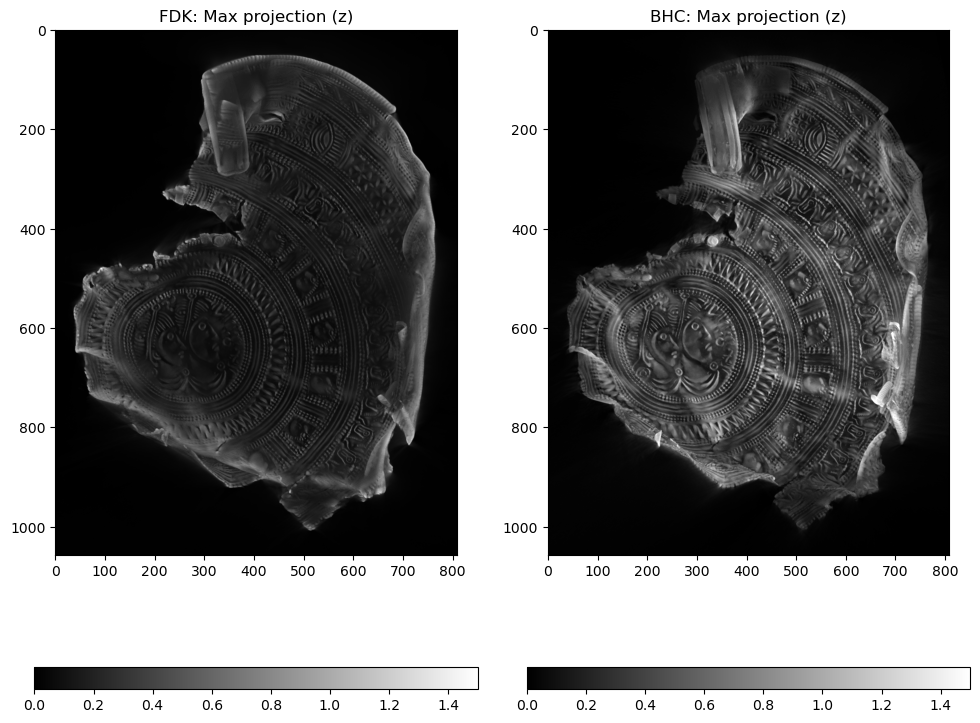

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

im_args = {
    'vmax': 1.5
}
plt.sca(ax[0])
plt.imshow(np.max(vol_FDK,axis=2), cmap='gray', **im_args)
plt.title('FDK: Max projection (z)')
plt.colorbar(location='bottom')

plt.sca(ax[1])
plt.imshow(np.max(vol_BHC,axis=2), cmap='gray', **im_args)#, vmax=1.0)
plt.title('BHC: Max projection (z)')
plt.colorbar(location='bottom')

plt.tight_layout()
plt.savefig('plots/X20_MIP_comparisons.pdf')

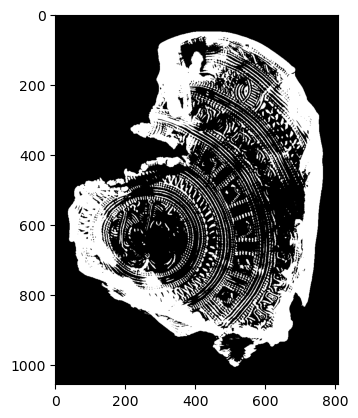

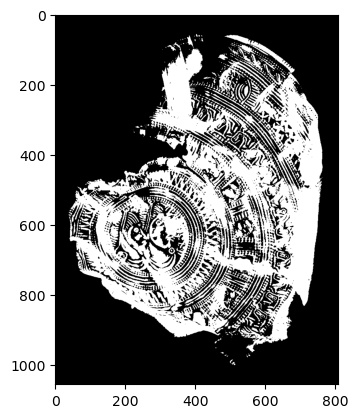

In [18]:
from skimage.filters import threshold_otsu

MIP_FDK = np.max(vol_FDK,axis=2)
MIP_BHC = np.max(vol_BHC,axis=2)

tau_FDK = threshold_otsu(MIP_FDK)
plt.imshow(MIP_FDK > tau_FDK, cmap='gray')
plt.show()

tau_BHC = threshold_otsu(MIP_BHC)
plt.imshow(MIP_BHC > tau_BHC, cmap='gray')
plt.show()

In [11]:
volF = vol_FDK
maxF = np.max(volF.flatten())
minF = np.min(volF.flatten())

volB = vol_BHC
maxB = np.max(volB.flatten())
minB = np.min(volB.flatten())

newMax = 1
newMin = 0
volF = (volF-minF) * (newMax-newMin)/(maxF-minF) + newMin
volB = (volB-minB) * (newMax-newMin)/(maxB-minB) + newMin

In [12]:
def total_variation2(image):
    dx = np.diff(image, axis=0)
    dy = np.diff(image, axis=1)
    dx = np.pad(dx, ((0, 1), (0, 0)), 'constant')
    dy = np.pad(dy, ((0, 0), (0, 1)), 'constant')
    tv = np.sum(np.sqrt(dx**2 + dy**2))
    return tv

print(total_variation2(np.max(volF,axis=2)))
print(total_variation2(np.max(volB,axis=2)))

6836.0
11750.0


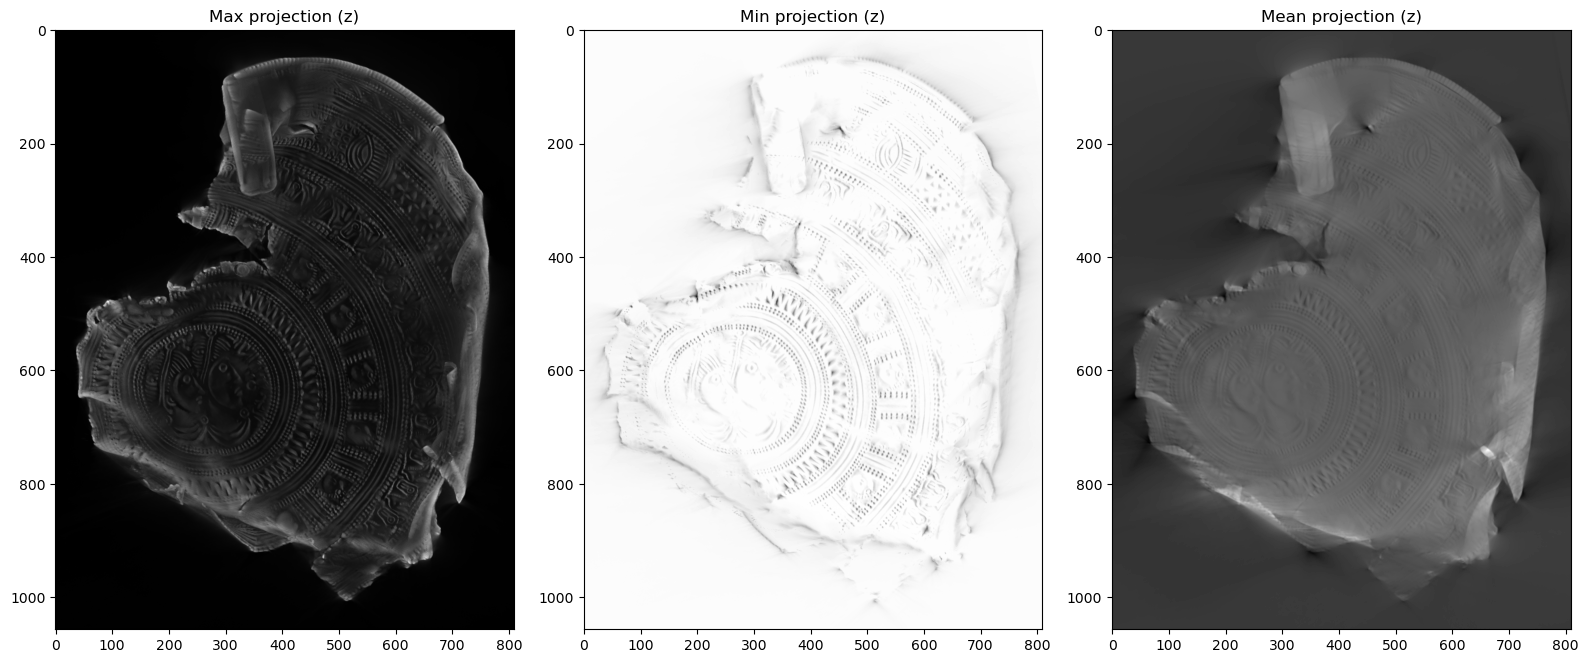

In [3]:
fig, ax = plt.subplots(1,3, figsize=(16, 8))
ax[0].imshow(np.max(vol_FDK,axis=2), cmap='gray')
ax[0].set_title('Max projection (z)')
ax[1].imshow(np.min(vol_FDK,axis=2), cmap='gray')
ax[1].set_title('Min projection (z)')
ax[2].imshow(np.mean(vol_FDK,axis=2), cmap='gray')
ax[2].set_title('Mean projection (z)')
plt.tight_layout()
# plt.savefig('plots/X20_z_projs.pdf')

In [4]:
def display_slices4(volume, axis=0, slices=None, rows=1, cols=None, slice_range=(None, None), fig_scale=1.0, include_endpoints=False, magnify=1.0, show=True):
    num_slices = volume.shape[axis]

    # Extract start and end from slice_range
    slice_start, slice_end = slice_range
    if slice_start is None:
        slice_start = 0
    if slice_end is None:
        slice_end = num_slices - 1

    if slices is None:
        slices = np.linspace(slice_start, slice_end, 5, dtype=int)
    if isinstance(slices, int):
        if include_endpoints:
            slices = np.linspace(slice_start, slice_end, slices, dtype=int)
        else:
            # Adjust the range to skip the very first and last points
            step = (slice_end - slice_start) / (slices + 1)
            new_start = slice_start + step
            new_end = slice_end - step
            slices = np.linspace(new_start, new_end, slices, dtype=int)

    total_slices = len(slices)

    if cols is None:
        # Calculate columns based on the number of rows and total slices
        cols = (total_slices + rows - 1) // rows  # Ceiling division

    # Adjust figure size based on the fig_scale parameter
    row_dim, col_dim = [volume.shape[i] for i in range(len(volume.shape)) if i != axis]
    row_prop, col_prop = row_dim/(row_dim+col_dim), col_dim/(row_dim+col_dim)
    fig, axs = plt.subplots(rows, cols, figsize=(col_prop * cols * 3 * fig_scale, row_prop * rows * 3 * fig_scale), squeeze=False)

    for i, slice_num in enumerate(slices):
        if magnify > 1.0:
            other_axes = [x for x in range(3) if x != axis]
            center = np.array(np.array(volume.shape)[other_axes]) // 2
            length = np.array(np.array(volume.shape)[other_axes]) // magnify
            min_idx = np.round(center - length // 2).astype(int)
            max_idx = np.round(center + length // 2).astype(int)

            if axis == 0:
                slice_data = volume[slice_num, min_idx[0]:max_idx[0], min_idx[1]:max_idx[1]]
            elif axis == 1:
                slice_data = volume[min_idx[0]:max_idx[0], slice_num, min_idx[1]:max_idx[1]]
            else:
                slice_data = volume[min_idx[0]:max_idx[0], min_idx[1]:max_idx[1], slice_num]
        else:
            if axis == 0:
                slice_data = volume[slice_num, :, :]
            elif axis == 1:
                slice_data = volume[:, slice_num, :]
            else:
                slice_data = volume[:, :, slice_num]

        ax = axs[i // cols, i % cols]
        ax.imshow(slice_data, cmap='gray')
        ax.axis('off')
        # Set subtitle in the upper left corner with a background
        # fontsize 12
        ax.text(0.05, 0.95, f'Slice {slice_num}', color='white', ha='left', va='top', fontsize=7 * fig_scale * 0.5, 
                transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

    # Hide any extra axes if there are more subplots than slices
    for j in range(i + 1, rows * cols):
        axs[j // cols, j % cols].axis('off')

    pad_size = 0.5
    plt.tight_layout(pad=0, h_pad= pad_size*fig_scale, w_pad=pad_size*fig_scale)
    if show: plt.show()

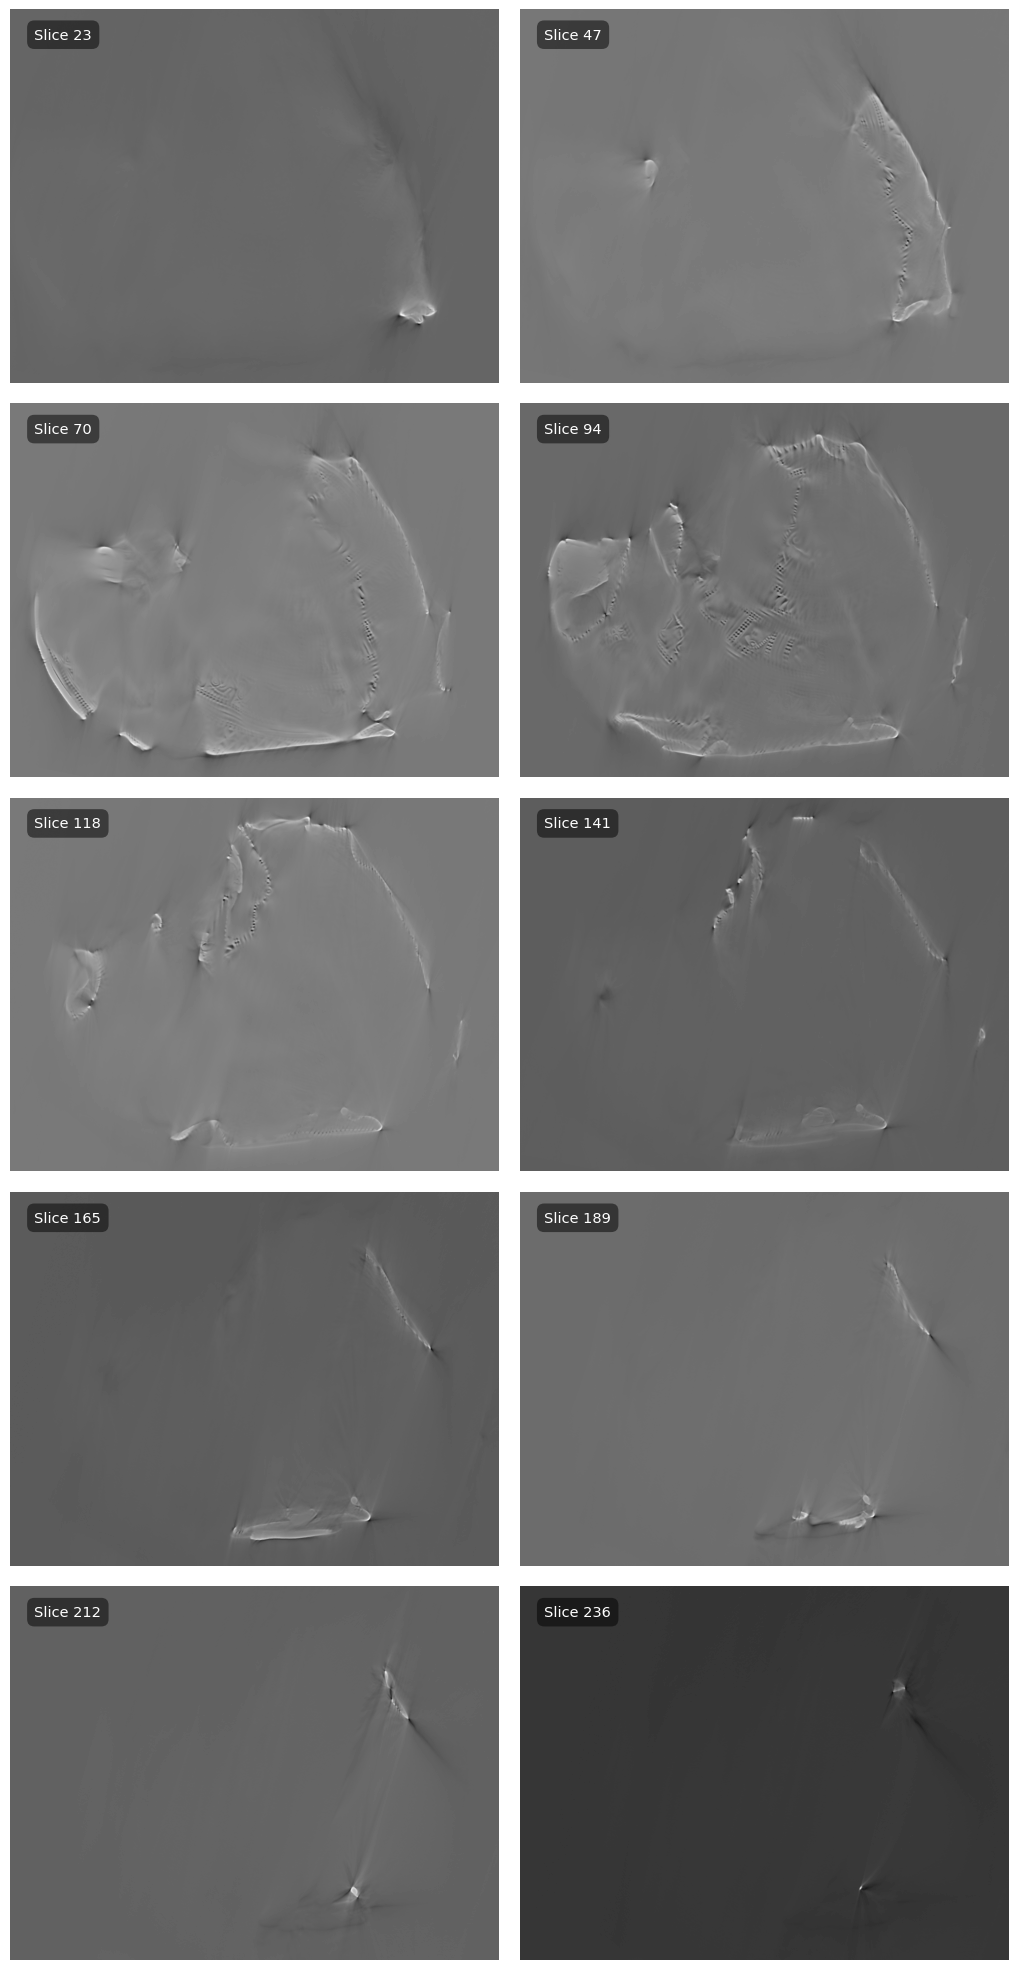

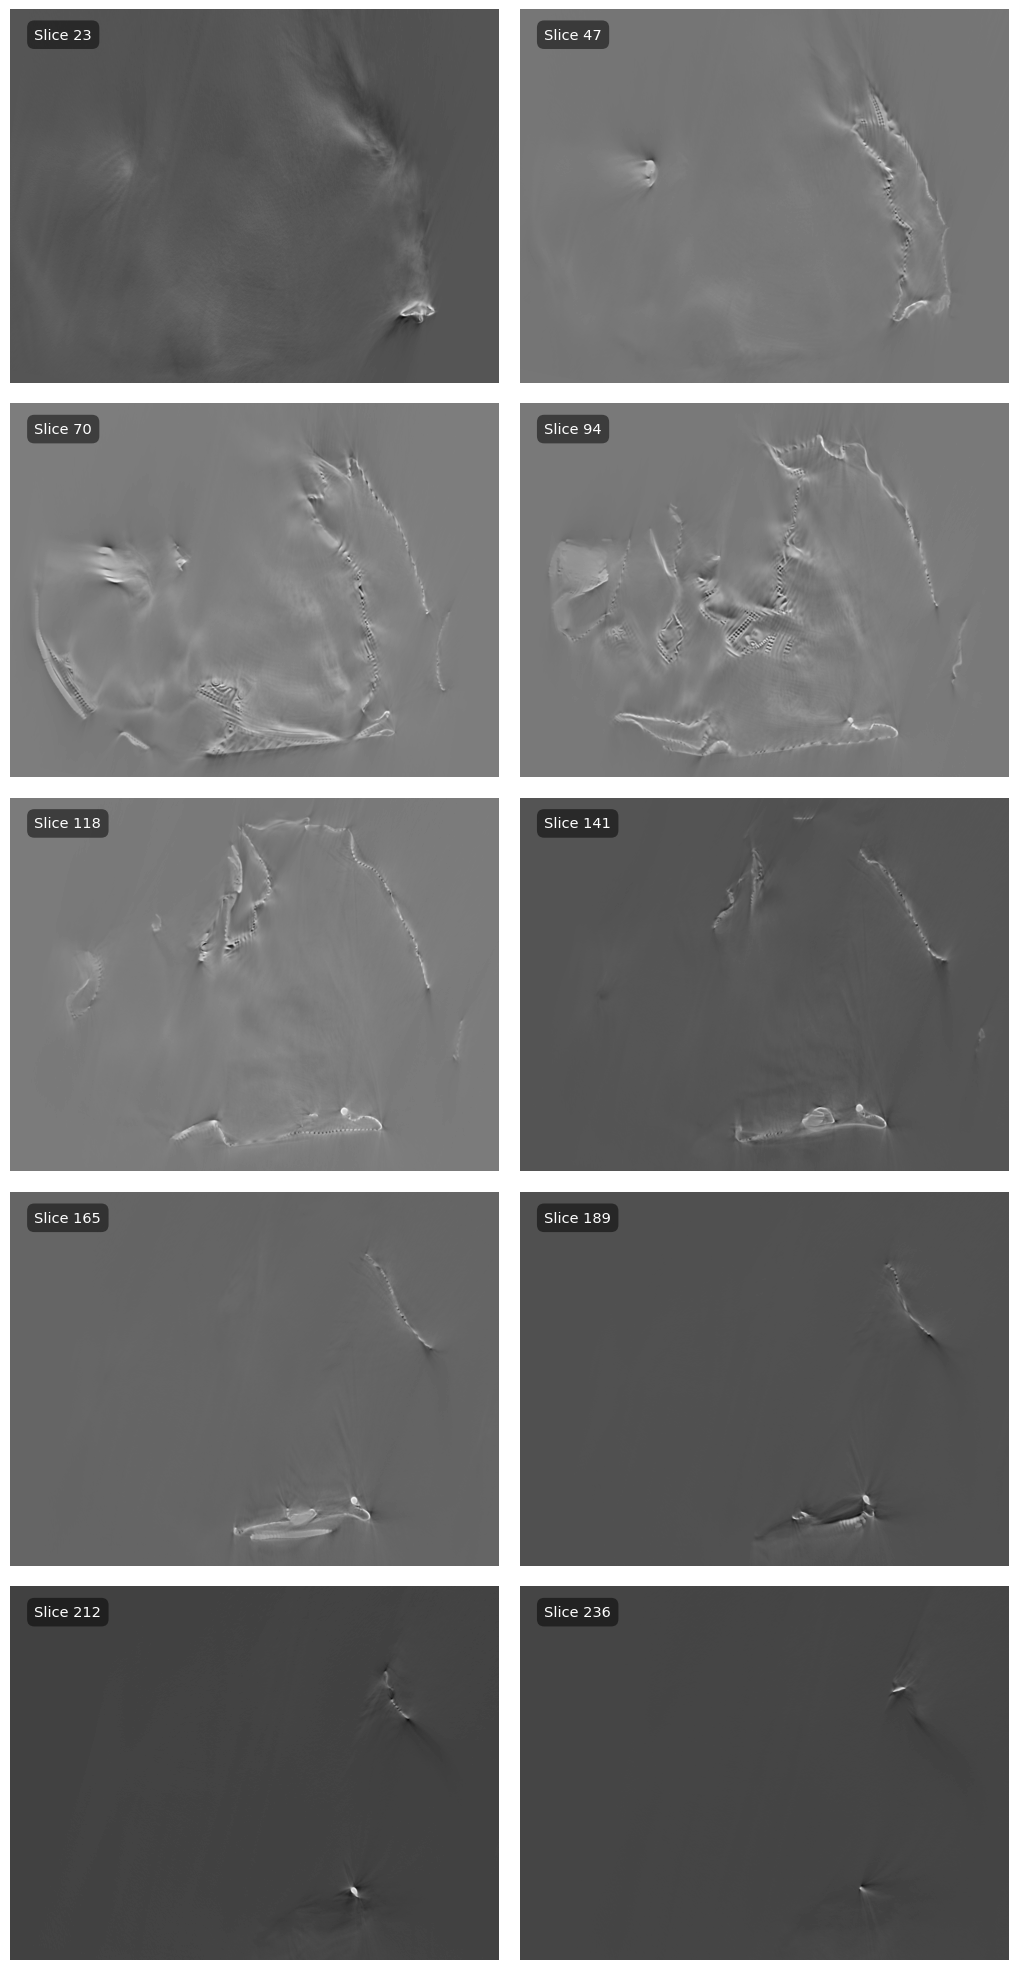

In [30]:
kwargs = {'axis': 0, 'slices': 10, 'rows': 5, 'fig_scale': 3.0}
display_slices4(vol_FDK.T, **kwargs)
display_slices4(vol_BHC.T, **kwargs)

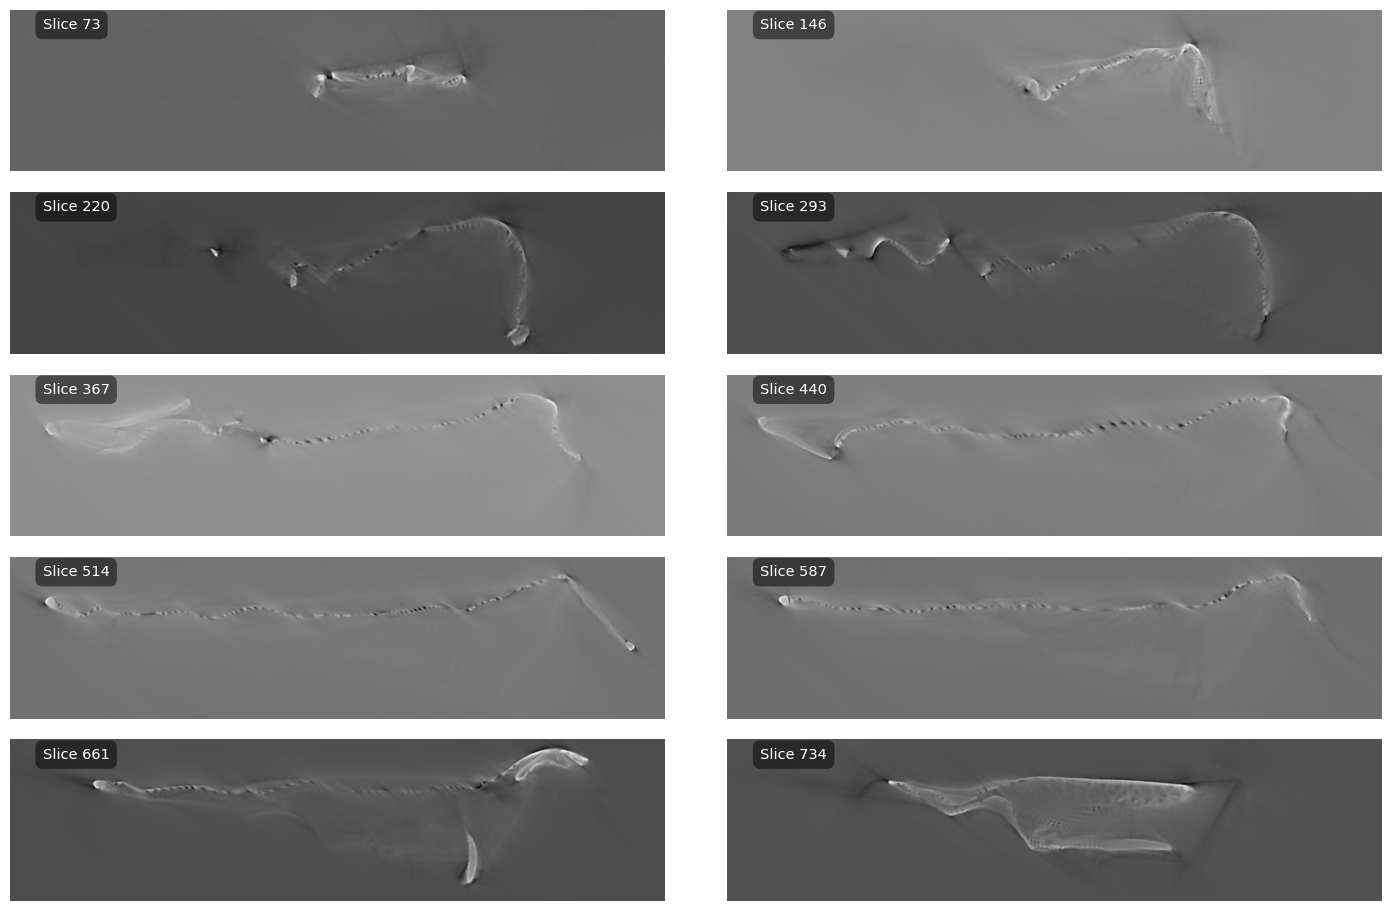

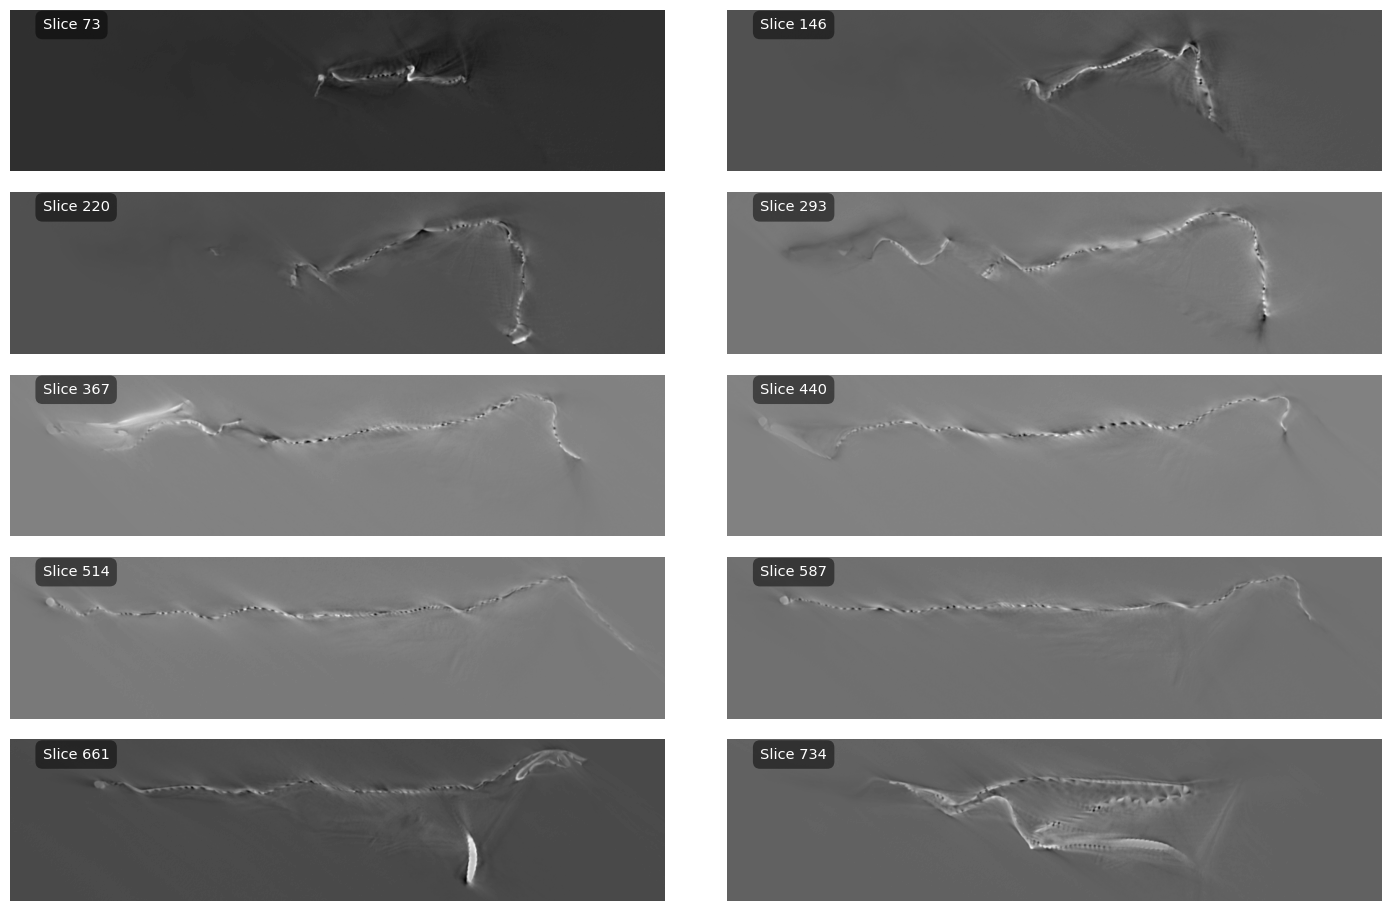

In [31]:
kwargs = {'axis': 1, 'slices': 10, 'rows': 5, 'fig_scale': 3.0}
display_slices4(vol_FDK.T, **kwargs)
display_slices4(vol_BHC.T, **kwargs)

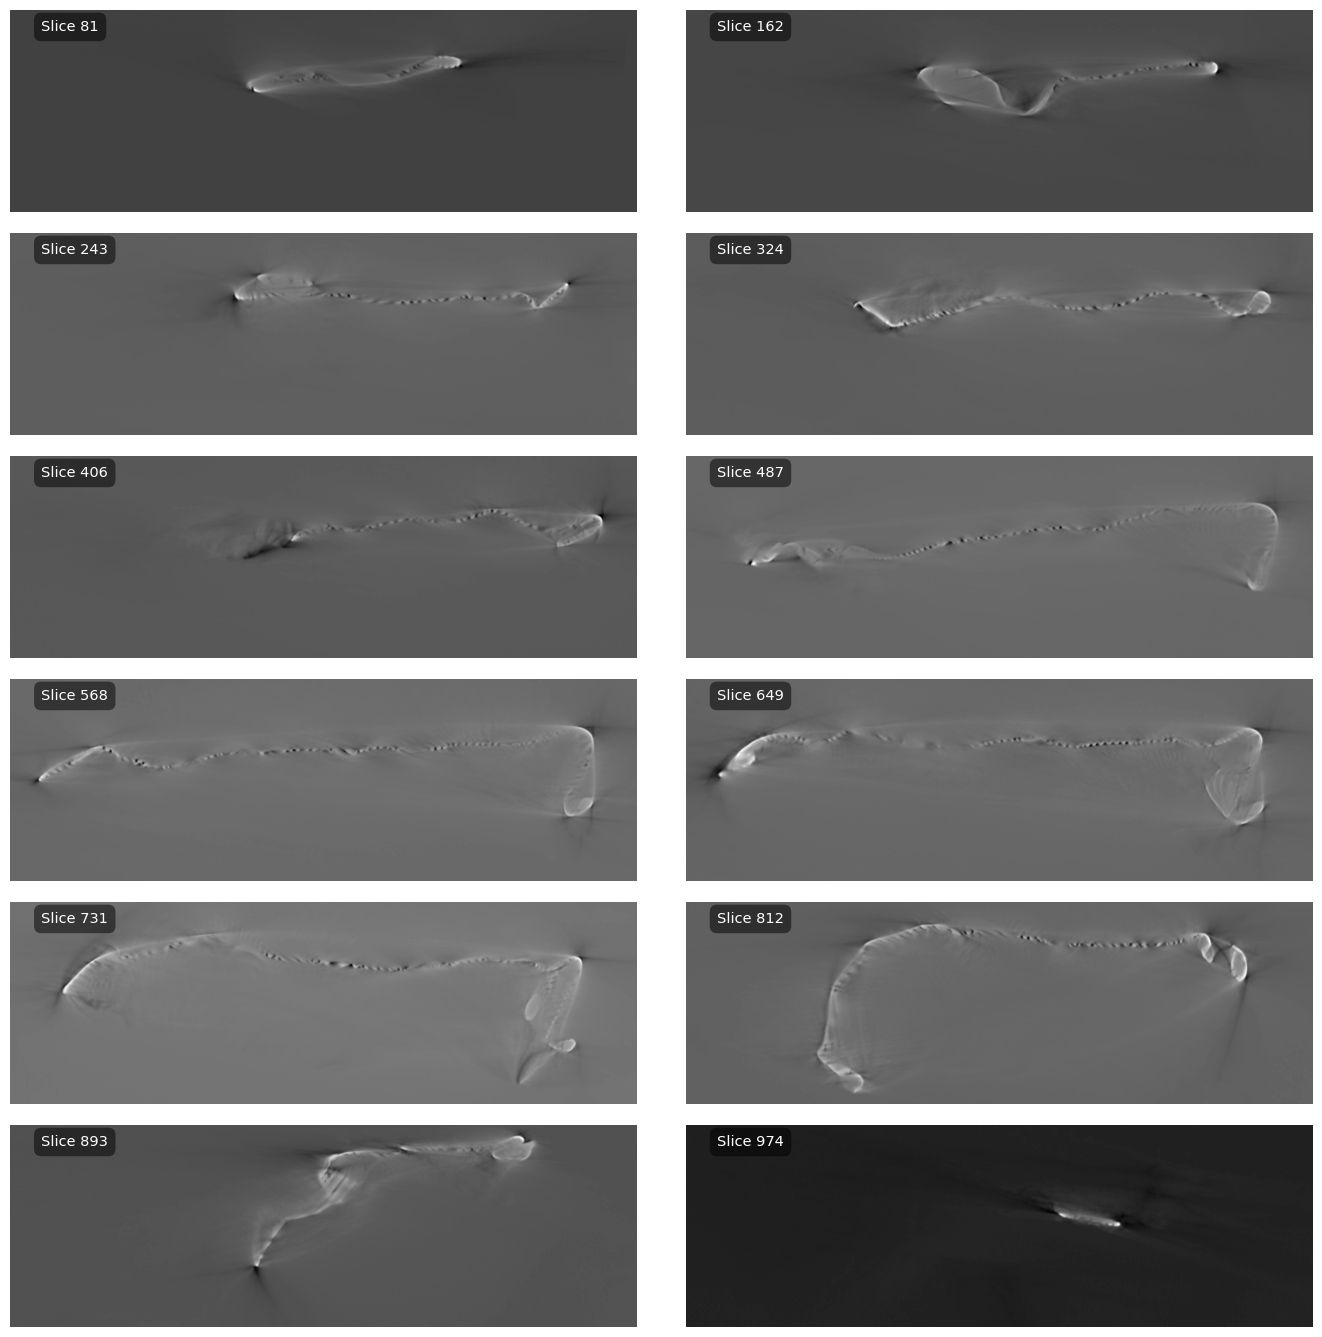

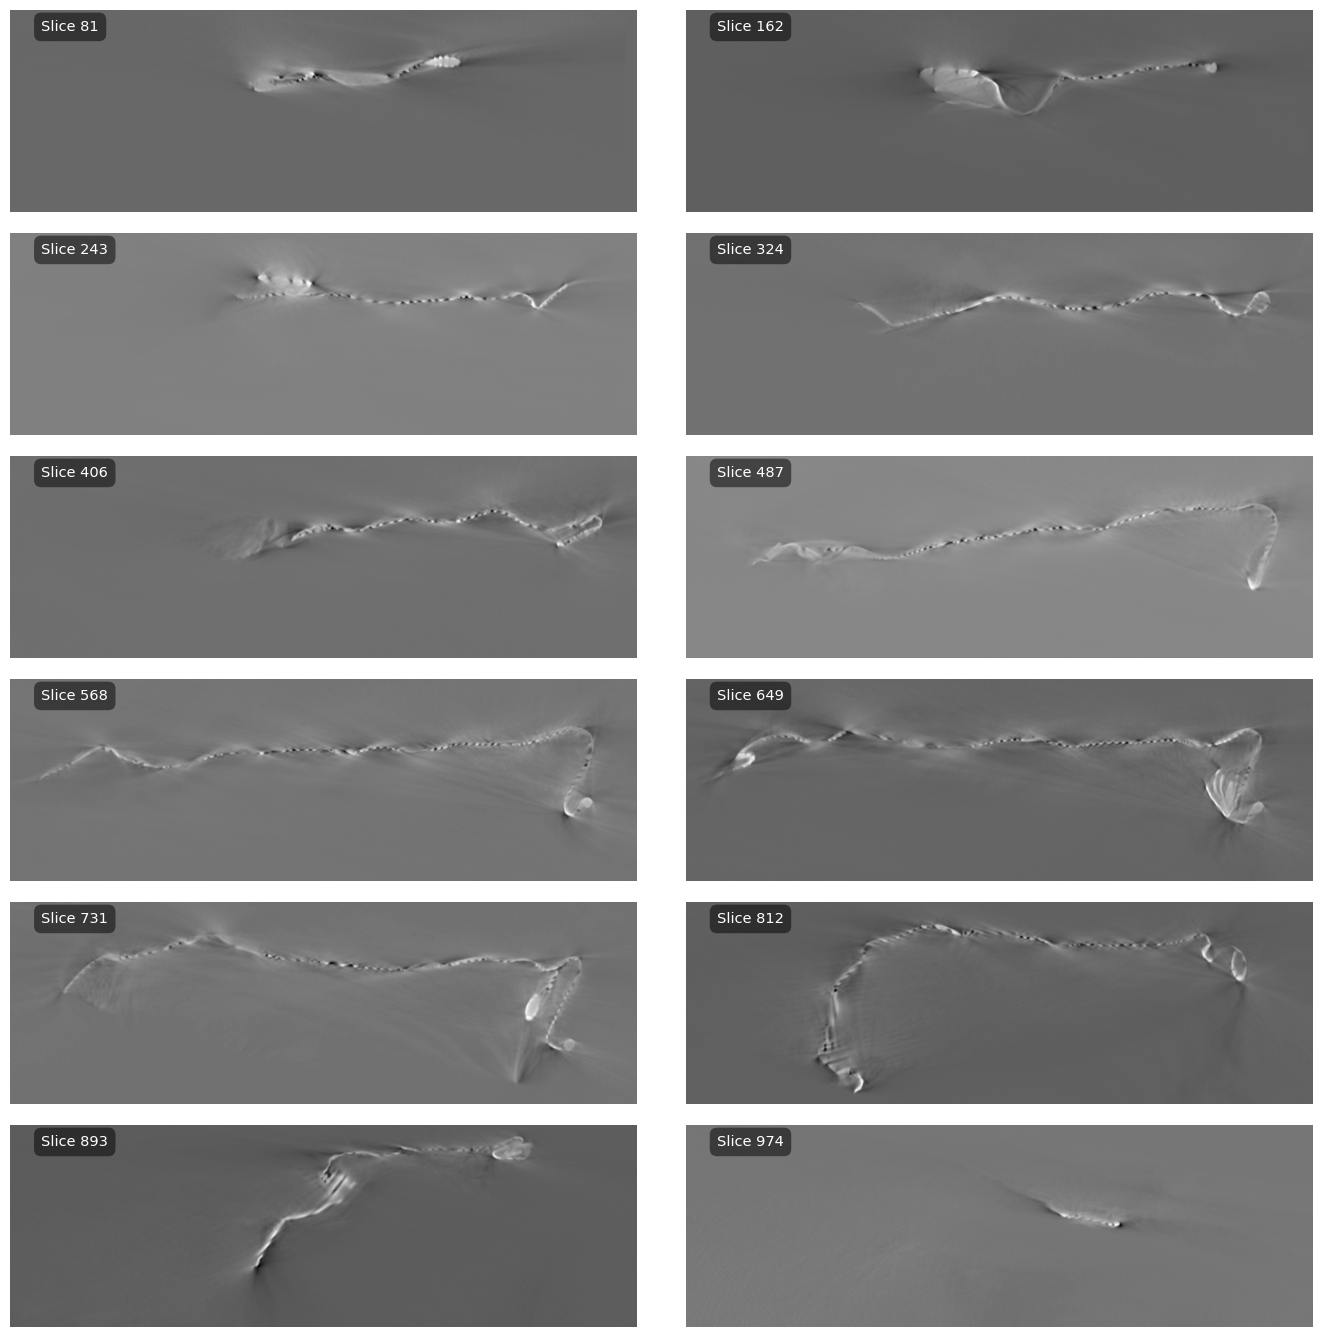

In [39]:
kwargs = {'axis': 2, 'slices': 12, 'rows': 6, 'fig_scale': 3.0}
display_slices4(vol_FDK.T, **kwargs)
display_slices4(vol_BHC.T, **kwargs)

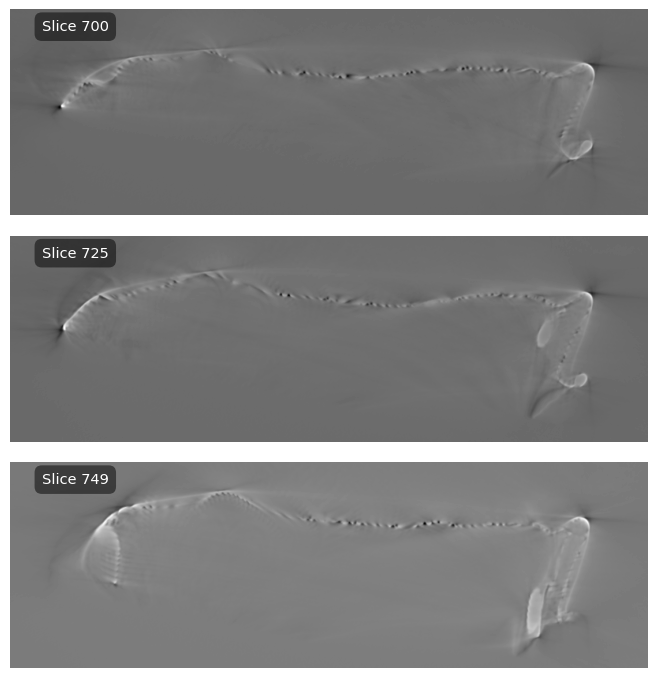

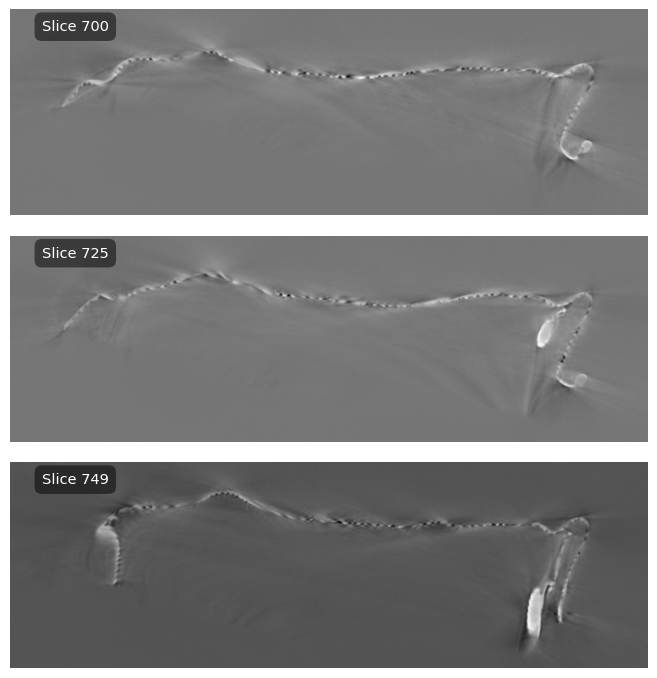

In [6]:
kwargs = {'axis': 2, 'slices': [700,725,749], 'rows': 3, 'fig_scale': 3.0}
display_slices4(vol_FDK.T, **kwargs)
display_slices4(vol_BHC.T, **kwargs)

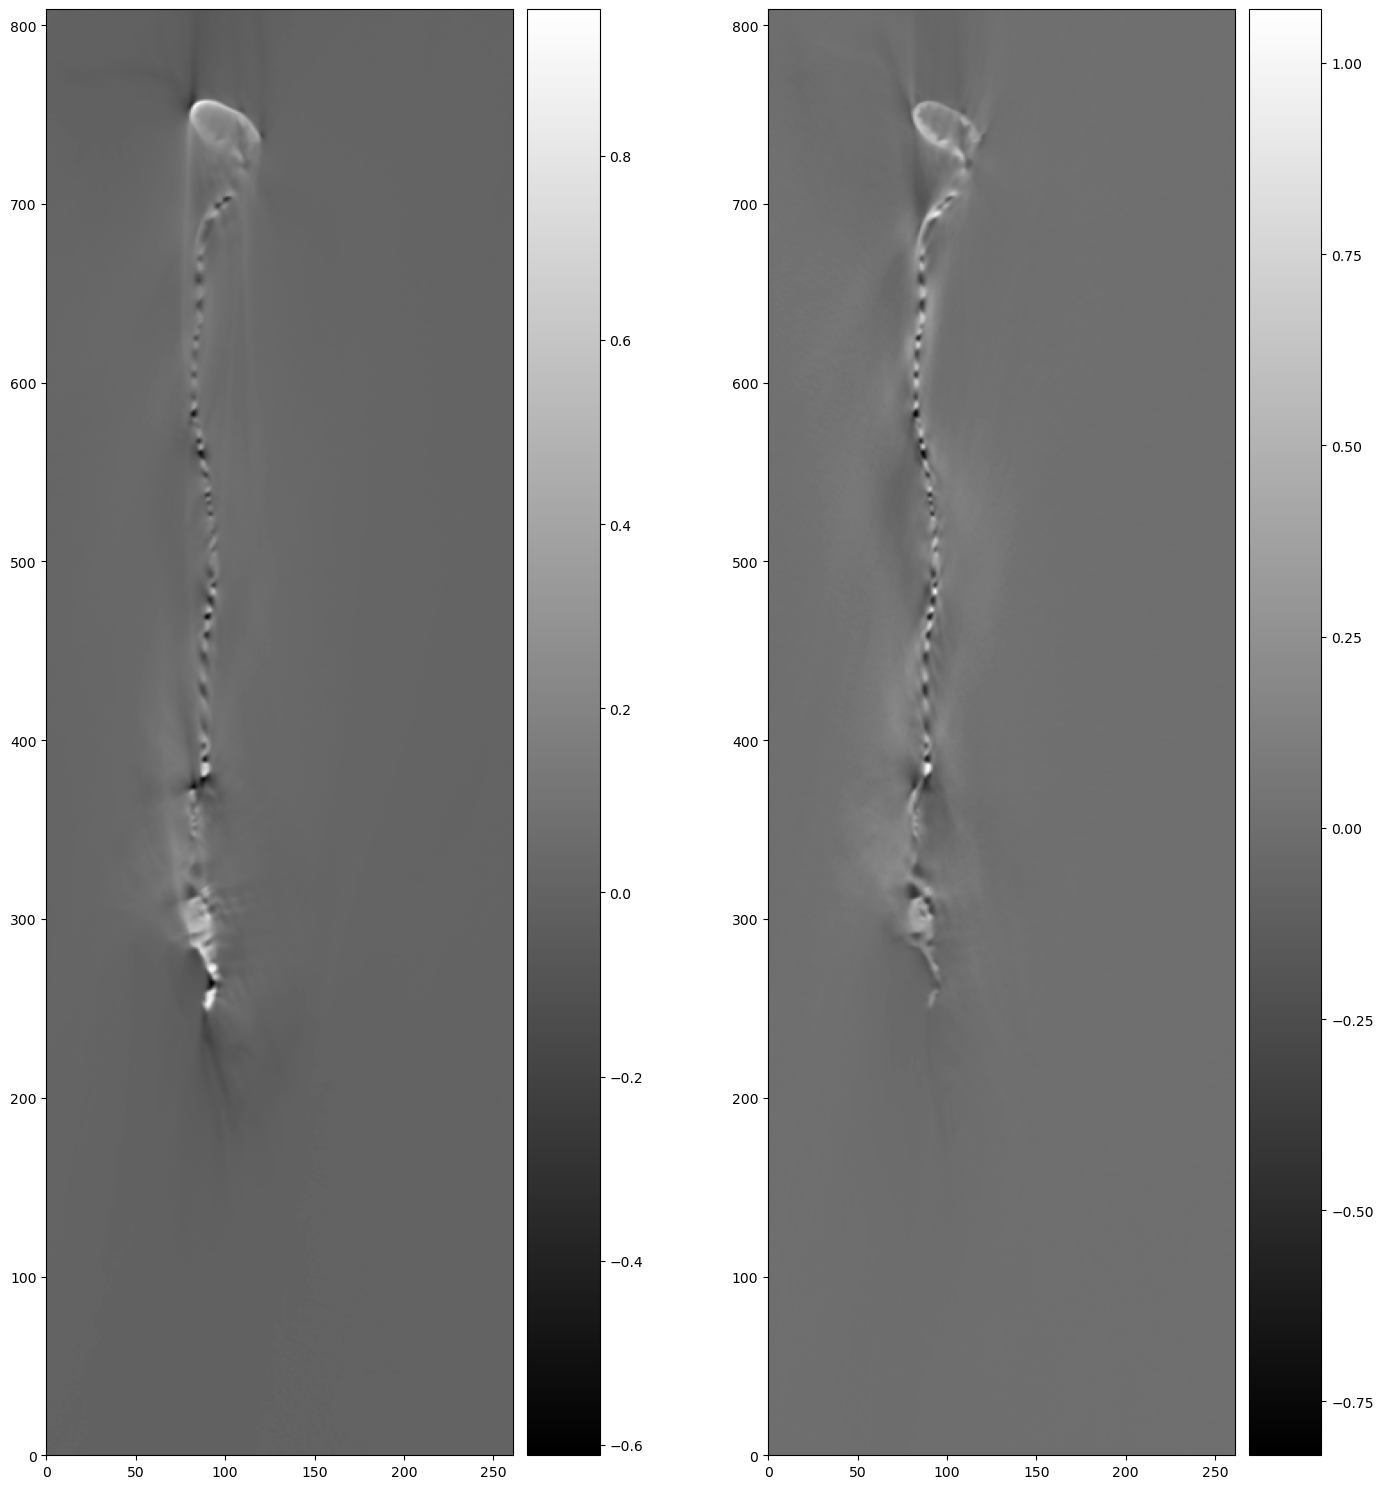

In [74]:
from cil.utilities.display import show2D
# axis,i = 1,720
axis,i = 0,350

slice_tuple = tuple(i if _ == axis else slice(None) for _ in range(3))
show2D([vol_FDK[slice_tuple],vol_BHC[slice_tuple]])

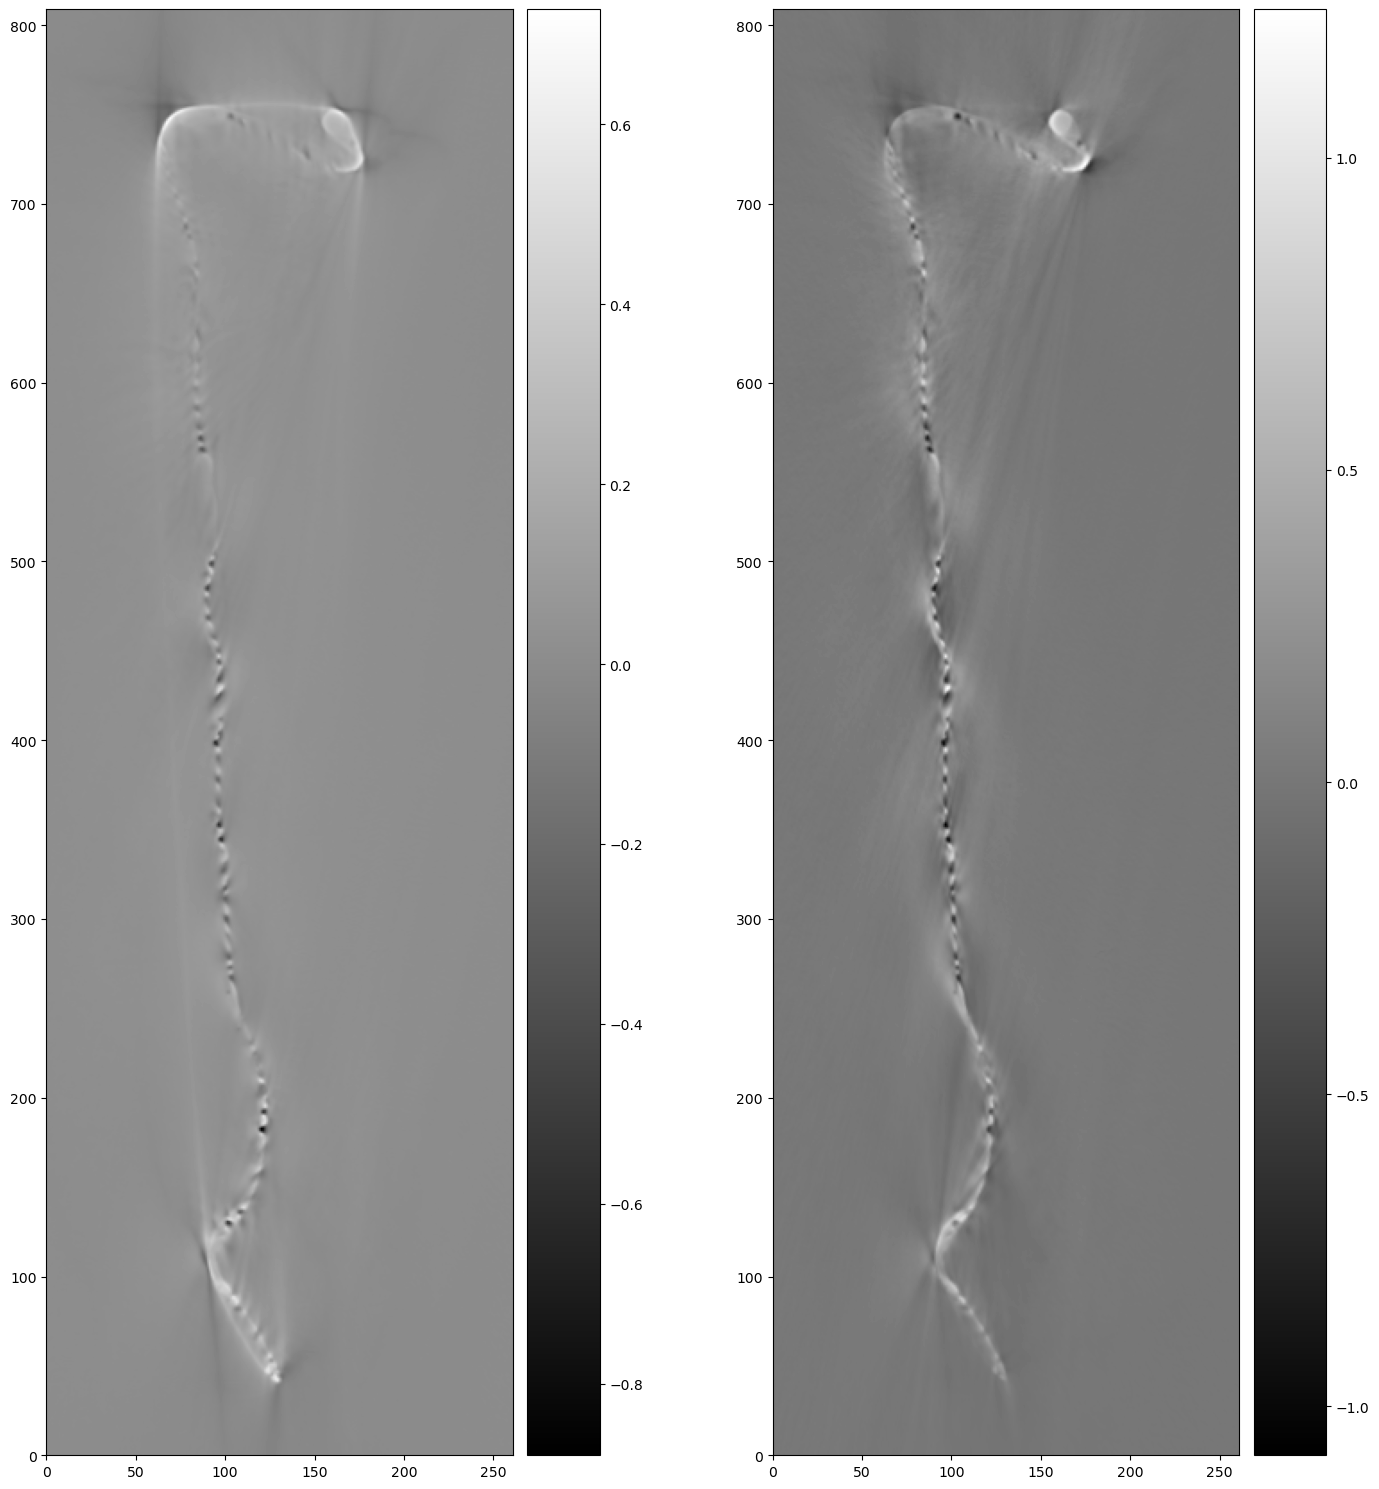

In [7]:
from cil.utilities.display import show2D
axis,i = 0,554
slice_tuple = tuple(i if _ == axis else slice(None) for _ in range(3))
show2D([vol_FDK[slice_tuple],vol_BHC[slice_tuple]])

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from skimage.measure import profile_line

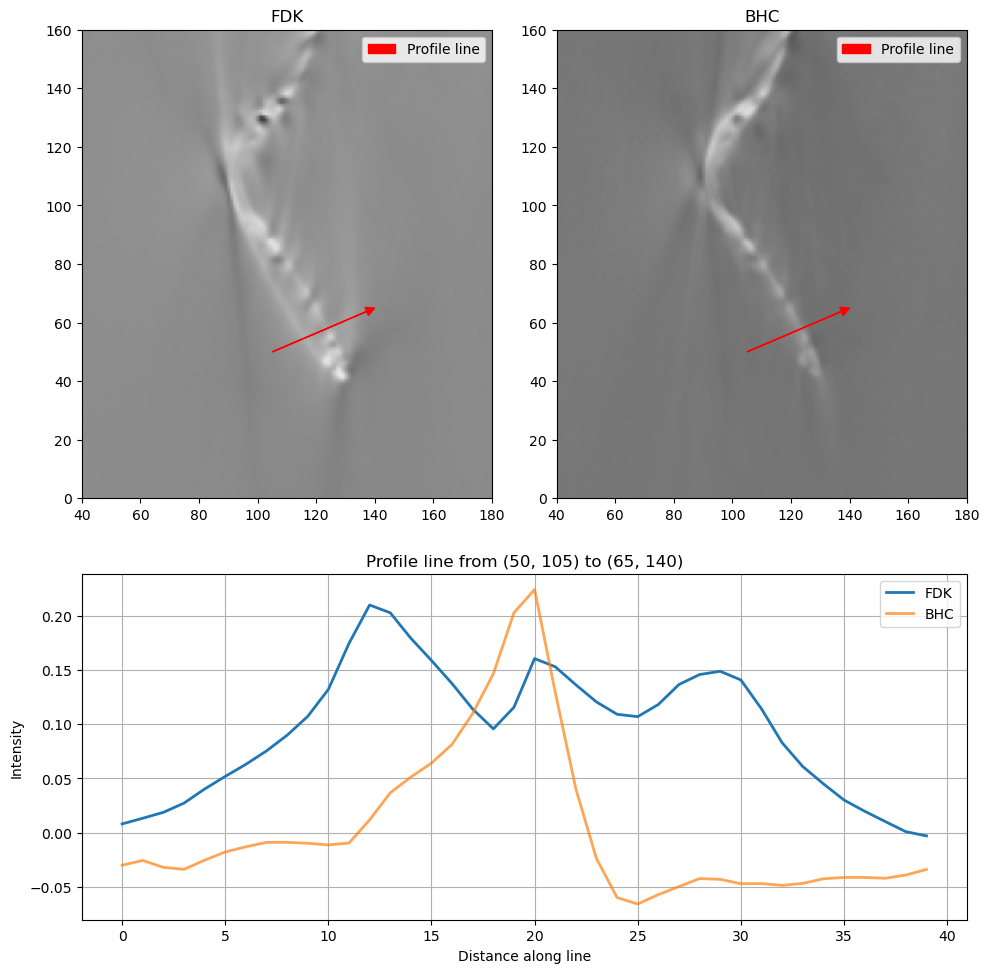

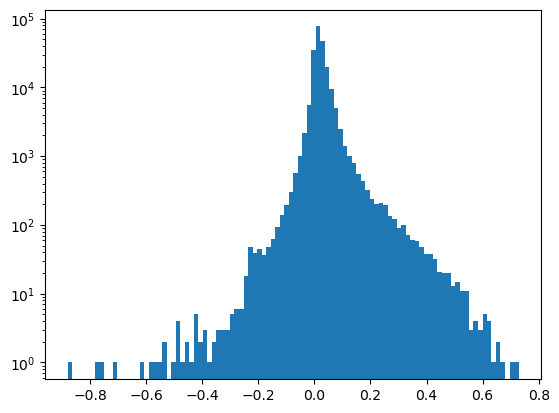

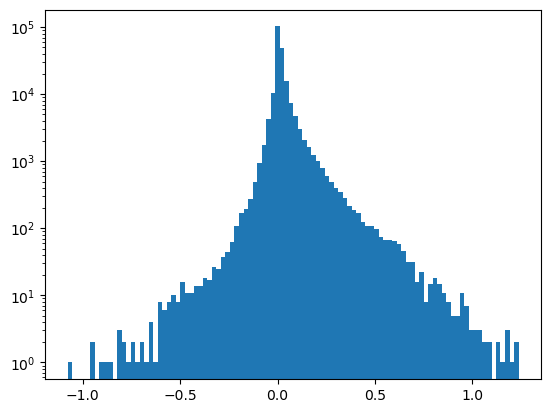

In [15]:
axis = 0
i = 554
# start, end = (50, 80), (95, 150)
# start, end = (50, 85), (80-5, 150)
# start, end = (50, 80), (80-10, 150)
start, end = (40, 80), (70, 150)
# print((end[1]-start[1])/(end[0]-start[0]))
# start, end = (45, 90), (70, 150)
start, end = (50, 105), (65, 140)

slice_tuple = tuple(i if _ == axis else slice(None) for _ in range(3))

sliceF = vol_FDK[slice_tuple]
sliceB = vol_BHC[slice_tuple]

xlim = (40, 180)
ylim = (0, 160)

fig = plt.figure(figsize=(10, 10))  # Adjust figsize if necessary
# fig = plt.figure()

# Create a gridspec with 2 rows, 2 columns
gs = fig.add_gridspec(2, 2, height_ratios=[1.5,1])

# First subplot (top left)
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(sliceF, cmap='gray')
# ax0.plot([start[1], end[1]], [start[0], end[0]], 'r--', label='Profile Line', linewidth=1.5)
ax0.arrow(start[1], start[0], (end[1] - start[1]), (end[0] - start[0]), head_width=3, head_length=3,
          fc='r', ec='r', length_includes_head=True, label='Profile line')
ax0.set_xlim(*xlim)
ax0.set_ylim(*ylim)
ax0.set_title("FDK")
ax0.legend()

# Second subplot (top right)
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(sliceB, cmap='gray')
ax1.arrow(start[1], start[0], (end[1] - start[1]), (end[0] - start[0]), head_width=3, head_length=3,
          fc='r', ec='r', length_includes_head=True, label='Profile line')
# ax1.plot([start[1], end[1]], [start[0], end[0]], 'k.', label='Profile Line', linewidth=1.5)

ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)
ax1.set_title("BHC")
ax1.legend()

# Third subplot (bottom, spans both columns)
ax2 = fig.add_subplot(gs[1, :])
pF = profile_line(sliceF.astype(np.float32), start, end)
pB = profile_line(sliceB.astype(np.float32), start, end)
ax2.plot(pF, label='FDK', linewidth=2)
ax2.plot(pB, label='BHC', linewidth=2, alpha=0.7)
ax2.set_ylabel('Intensity')
ax2.set_xlabel('Distance along line')
ax2.set_title(f'Profile line from {start} to {end}')
ax2.grid(True)
ax2.legend()

# Adjust layout to minimize whitespace
plt.tight_layout()
# plt.savefig('plots/X20_segm_comparison1.pdf')
plt.show()


# nbins = 100
# plt.hist(sliceF.flatten(),bins=nbins)
# plt.yscale('log')
# plt.show()
# plt.hist(sliceB.flatten(),bins=nbins)
# plt.yscale('log')
# plt.show()

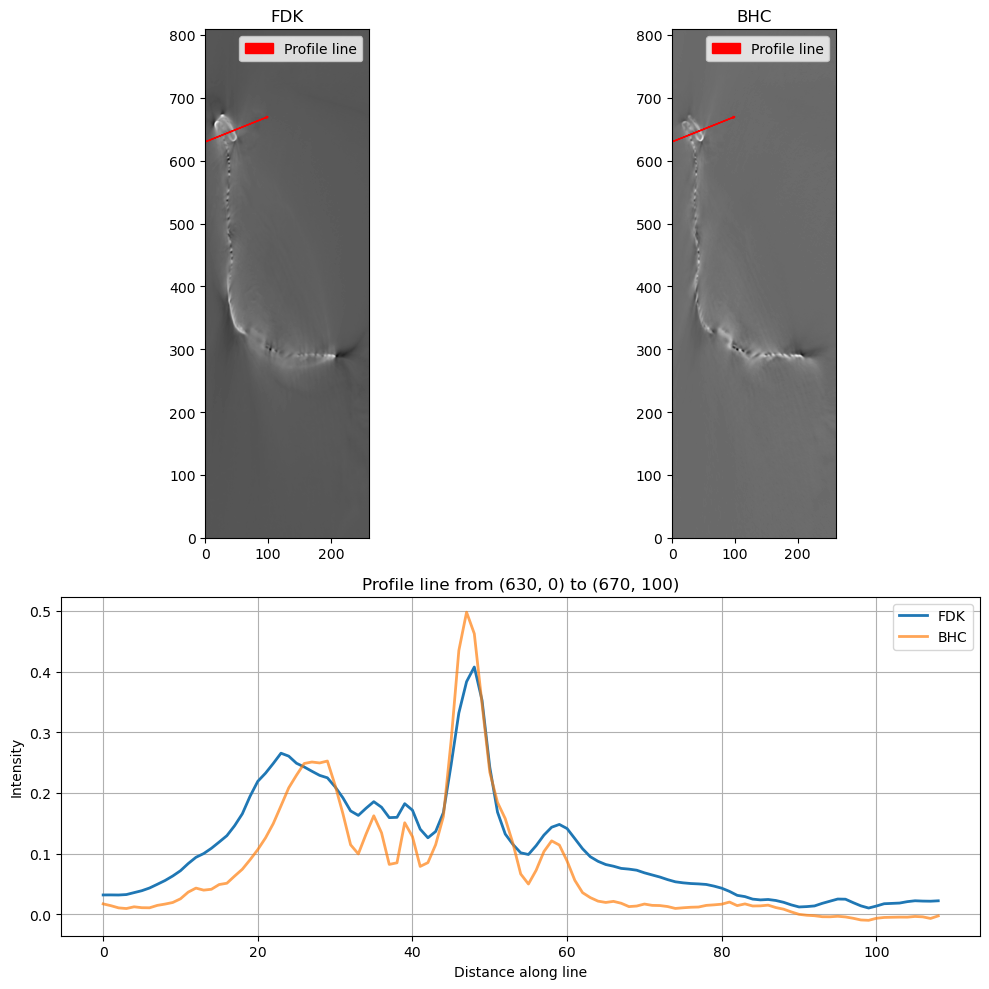

In [50]:
axis = 0
i = 864
start, end = (630,0), (670,100)

slice_tuple = tuple(i if _ == axis else slice(None) for _ in range(3))

sliceF = vol_FDK[slice_tuple]
sliceB = vol_BHC[slice_tuple]

xlim = (0,sliceF.shape[1])
ylim = (0,sliceF.shape[0])

# xlim = (40, 180)
# ylim = (0, 160)

fig = plt.figure(figsize=(10, 10))  # Adjust figsize if necessary
# fig = plt.figure()

# Create a gridspec with 2 rows, 2 columns
gs = fig.add_gridspec(2, 2, height_ratios=[1.5,1])

# First subplot (top left)
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(sliceF, cmap='gray')
# ax0.plot([start[1], end[1]], [start[0], end[0]], 'r--', label='Profile Line', linewidth=1.5)
ax0.arrow(start[1], start[0], (end[1] - start[1]), (end[0] - start[0]), head_width=3, head_length=3,
          fc='r', ec='r', length_includes_head=True, label='Profile line')
ax0.set_xlim(*xlim)
ax0.set_ylim(*ylim)
ax0.set_title("FDK")
ax0.legend()

# Second subplot (top right)
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(sliceB, cmap='gray')
ax1.arrow(start[1], start[0], (end[1] - start[1]), (end[0] - start[0]), head_width=3, head_length=3,
          fc='r', ec='r', length_includes_head=True, label='Profile line')
# ax1.plot([start[1], end[1]], [start[0], end[0]], 'k.', label='Profile Line', linewidth=1.5)

ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)
ax1.set_title("BHC")
ax1.legend()

# Third subplot (bottom, spans both columns)
ax2 = fig.add_subplot(gs[1, :])
pF = profile_line(sliceF.astype(np.float32), start, end)
pB = profile_line(sliceB.astype(np.float32), start, end)
ax2.plot(pF, label='FDK', linewidth=2)
ax2.plot(pB, label='BHC', linewidth=2, alpha=0.7)
ax2.set_ylabel('Intensity')
ax2.set_xlabel('Distance along line')
ax2.set_title(f'Profile line from {start} to {end}')
ax2.grid(True)
ax2.legend()

# Adjust layout to minimize whitespace
plt.tight_layout()
# plt.savefig('plots/X20_segm_comparison1.pdf')
plt.show()

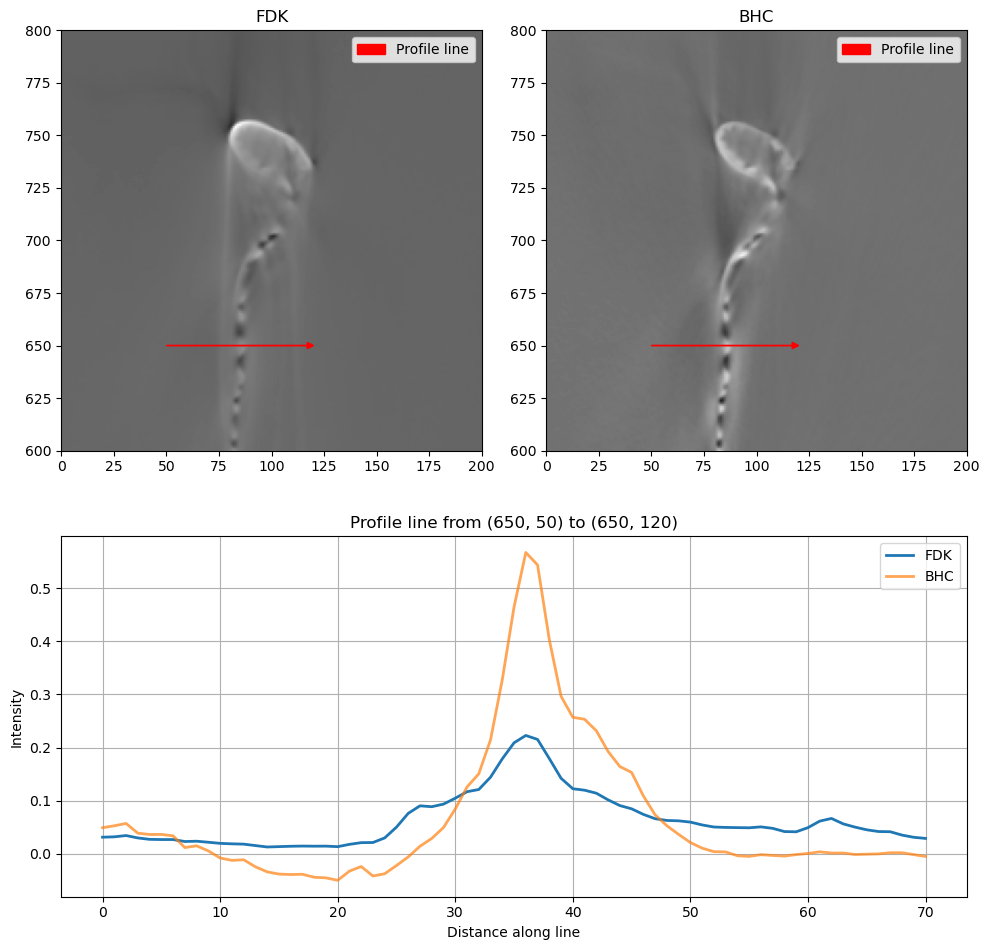

In [81]:
axis = 0
i = 350
start, end = (650,50), (650,120)

slice_tuple = tuple(i if _ == axis else slice(None) for _ in range(3))

sliceF = vol_FDK[slice_tuple]
sliceB = vol_BHC[slice_tuple]

xlim = (0,sliceF.shape[1])
ylim = (0,sliceF.shape[0])

xlim = (0, 200)
ylim = (600,800)

fig = plt.figure(figsize=(10, 10))  # Adjust figsize if necessary
# fig = plt.figure()

# Create a gridspec with 2 rows, 2 columns
gs = fig.add_gridspec(2, 2, height_ratios=[1.5,1])

# First subplot (top left)
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(sliceF, cmap='gray')
# ax0.plot([start[1], end[1]], [start[0], end[0]], 'r--', label='Profile Line', linewidth=1.5)
ax0.arrow(start[1], start[0], (end[1] - start[1]), (end[0] - start[0]), head_width=3, head_length=3,
          fc='r', ec='r', length_includes_head=True, label='Profile line')
ax0.set_xlim(*xlim)
ax0.set_ylim(*ylim)
ax0.set_title("FDK")
ax0.legend()

# Second subplot (top right)
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(sliceB, cmap='gray')
ax1.arrow(start[1], start[0], (end[1] - start[1]), (end[0] - start[0]), head_width=3, head_length=3,
          fc='r', ec='r', length_includes_head=True, label='Profile line')
# ax1.plot([start[1], end[1]], [start[0], end[0]], 'k.', label='Profile Line', linewidth=1.5)

ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)
ax1.set_title("BHC")
ax1.legend()

# Third subplot (bottom, spans both columns)
ax2 = fig.add_subplot(gs[1, :])
pF = profile_line(sliceF.astype(np.float32), start, end)
pB = profile_line(sliceB.astype(np.float32), start, end)
ax2.plot(pF, label='FDK', linewidth=2)
ax2.plot(pB, label='BHC', linewidth=2, alpha=0.7)
ax2.set_ylabel('Intensity')
ax2.set_xlabel('Distance along line')
ax2.set_title(f'Profile line from {start} to {end}')
ax2.grid(True)
ax2.legend()

# Adjust layout to minimize whitespace
plt.tight_layout()
# plt.savefig('plots/X20_segm_comparison1.pdf')
plt.show()